## "Arctic Rivers" Exploratory Data Analysis
#### Modeled Stream Temperature and Stream Flow Data

This notebook is for exploring data from the Arctic Rivers Project, sponsored by NSF NNA. The goal is to see what we are working with here, asking questions that are relevant to how this data could be integrated into NCR, ARDAC, or similar.

Context: co-developed with Indigenous partners a model chain that involves dynamic downscaling (4 km) of a calibrated RASM/WRF/CSM configuration for a historical 30 yr period, and two mid-century simulations using the delta-method, and four downscaled CESM2 LE members each for historical and mid-century 30-yr periods. Simulations have been routed to estimate streamflow and (calibrated) river temperatures (paper in press) for AK and YK rivers. 

The modeled stream temp and stream flow data values are mapped to the [MERIT HYDRO](https://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro/) raster stream network, where individual stream segments are given unique stream IDs that are referenced in this dataset. Therefore, the dataset for this project **does not** include spatially explicit data, but instead references an existing spatial dataset. One of our tasks will be to link these datasets together for visualization of the modeled values in time and space.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

# path to data is /beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/
data_dir = Path("/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/")

#### Data package
All netCDFs, all files have a 3 part name structure:

In [5]:
fps = list(data_dir.glob("*"))
assert all(fp == fp2 for fp, fp2 in zip(fps, data_dir.glob("*.nc")))
print(f"Number of files: {len(fps)}\n")

assert all([len(fp.name.split("_")) == 3 for fp in fps])
print("Some random files:")

print(fps[0].name)
print(fps[200].name)
print(fps[999].name)

Number of files: 1056

Some random files:
2056_fC2LE2_climate.nc
2019_hC2LE9_WT.nc
2009_historical_climate.nc


Looks like we have `<year>_<model>_<variables>.nc` , with the following possible values:

In [6]:
years, models_, variables_ = zip(*[fp.name.split(".")[0].split("_") for fp in fps])
models = list(set(models_))
variables = list(set(variables_))
print(f"year -- first year: {min(years)}, last year: {max(years)}")
print(f"models: {sorted(set(models))}")
print(f"scenarios: {set(variables)}")

year -- first year: 1990, last year: 2065
models: ['fC2LE2', 'fC2LE4', 'fC2LE7', 'fC2LE9', 'fPGWh', 'fPGWm', 'hC2LE2', 'hC2LE4', 'hC2LE7', 'hC2LE9', 'historical']
scenarios: {'Q', 'WT', 'climate'}


`Q` is stream flow, `WT` is water temperature, and `climate` is the forcing using for the hydrological model(s). 

We need more metadata to know what the model codes refer to, and how "historical" differs from modeled historical.

Mean file sizes:

In [7]:
rows = []
for model in models:
    for var in variables:
        modvar_sizes = []
        for year in range(1990, 2066):
            fp = data_dir.joinpath(f"{year}_{model}_{var}.nc")
            if not fp.exists():
                continue
            else:
                size = fp.stat().st_size / 1e6
                modvar_sizes.append(size)

        rows.append(
            {
                "model": model,
                "var": var,
                "mean_size": f"{np.mean(modvar_sizes).astype(int)} MB",
                "std_size": f"{np.std(modvar_sizes).astype(int)} MB",
            }
        )

df = pd.DataFrame(rows)

In [8]:
df.pivot(index="var", columns="model", values="mean_size")

model,fC2LE2,fC2LE4,fC2LE7,fC2LE9,fPGWh,fPGWm,hC2LE2,hC2LE4,hC2LE7,hC2LE9,historical
var,,,,,,,,,,,
Q,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,52 MB
WT,594 MB,594 MB,594 MB,594 MB,595 MB,595 MB,594 MB,594 MB,594 MB,594 MB,595 MB
climate,969 MB,969 MB,971 MB,971 MB,966 MB,969 MB,986 MB,990 MB,987 MB,988 MB,981 MB


Standard deviations:

In [9]:
df.pivot(index="var", columns="model", values="std_size")

model,fC2LE2,fC2LE4,fC2LE7,fC2LE9,fPGWh,fPGWm,hC2LE2,hC2LE4,hC2LE7,hC2LE9,historical
var,,,,,,,,,,,
Q,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB
WT,28 MB,28 MB,28 MB,28 MB,26 MB,26 MB,28 MB,28 MB,28 MB,28 MB,26 MB
climate,46 MB,50 MB,46 MB,48 MB,46 MB,45 MB,47 MB,47 MB,47 MB,48 MB,45 MB


What about representation of models / vairable groups in the dataset?

In [10]:
unique_models, counts = np.unique(models_, return_counts=True)
pd.DataFrame({"Model": models, "File count": counts})

,Model,File count
0,hC2LE9,96
1,fPGWm,96
2,hC2LE7,96
3,historical,96
4,hC2LE4,96
5,fC2LE4,96
6,fC2LE9,96
7,fPGWh,96
8,fC2LE7,96
9,hC2LE2,96


In [11]:
unique_groups, counts = np.unique(variables_, return_counts=True)
pd.DataFrame({"Variable group": unique_groups, "File count": counts})

,Variable group,File count
0,Q,352
1,WT,352
2,climate,352


#### File structure and values
Examine some files from model `hC2LE7` in year 1990 only, plus `historical` from 1990

In [12]:
fps = list(data_dir.glob('1990*hC2LE7*.nc'))
hist = list(data_dir.glob('1990*historical*.nc'))
fps += hist
fps

[PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1990_hC2LE7_WT.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1990_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1990_hC2LE7_climate.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1990_historical_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1990_historical_climate.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1990_historical_WT.nc')]

Separate modeled from historical files to check to see if structure is the same.

In [13]:
wt_modeled = xr.open_dataset(fps[0])
q_modeled = xr.open_dataset(fps[1])
clim_modeled = xr.open_dataset(fps[2])

q_hist = xr.open_dataset(fps[3])
clim_hist = xr.open_dataset(fps[4])
wt_hist = xr.open_dataset(fps[5])

##### Water temperature
`no_seg` is probably "number of segments"
`hru` is probably "hydrological response unit" - this is the unique ID of the MERIT HYDRO river segment, not an actual float value


In [5]:
wt_modeled

<xarray.Dataset> Size: 600MB
Dimensions:      (time: 365, no_seg: 2, hru: 34208)
Coordinates:
  * time         (time) datetime64[ns] 3kB 1990-01-01 1990-01-02 ... 1990-12-31
  * no_seg       (no_seg) int32 8B 1 2
  * hru          (hru) float64 274kB 8.1e+07 8.1e+07 ... 8.103e+07 8.103e+07
Data variables:
    T_stream     (time, no_seg, hru) float64 200MB ...
    T_air        (time, no_seg, hru) float64 200MB ...
    T_headwater  (time, no_seg, hru) float64 200MB ...

In [6]:
wt_hist

<xarray.Dataset> Size: 600MB
Dimensions:      (time: 365, no_seg: 2, hru: 34208)
Coordinates:
  * hru          (hru) float64 274kB 8.103e+07 8.103e+07 ... 8.103e+07 8.103e+07
  * no_seg       (no_seg) int32 8B 1 2
  * time         (time) datetime64[ns] 3kB 1990-01-01 1990-01-02 ... 1990-12-31
Data variables:
    T_air        (time, no_seg, hru) float64 200MB ...
    T_headwater  (time, no_seg, hru) float64 200MB ...
    T_stream     (time, no_seg, hru) float64 200MB ...
Attributes:
    history:  Sat May 18 08:04:24 2024: ncks --mk_rec_dmn time /glade/derecho...
    NCO:      netCDF Operators version 5.1.9 (Homepage = http://nco.sf.net, C...

Compare modeled vs historical for a water temperature from a certain date, segment, and hru.

In [14]:
print(wt_modeled['T_stream'].sel(time='1990-01-01', no_seg=1, hru=81000076).values)
print(wt_hist['T_stream'].sel(time='1990-01-01', no_seg=1, hru=81000076).values)

1.84
3.74


Now compare the modeled data for the two different `no_seg` dimensions.

In [17]:
print(wt_modeled['T_stream'].sel(time='1990-01-01', no_seg=1, hru=81000076).values)
print(wt_modeled['T_stream'].sel(time='1990-01-01', no_seg=2, hru=81000076).values)

1.84
1.46


Pretty close...let's plot all the values from 1990 for all temp variables, plotting the `no_seg` options on top of each other.

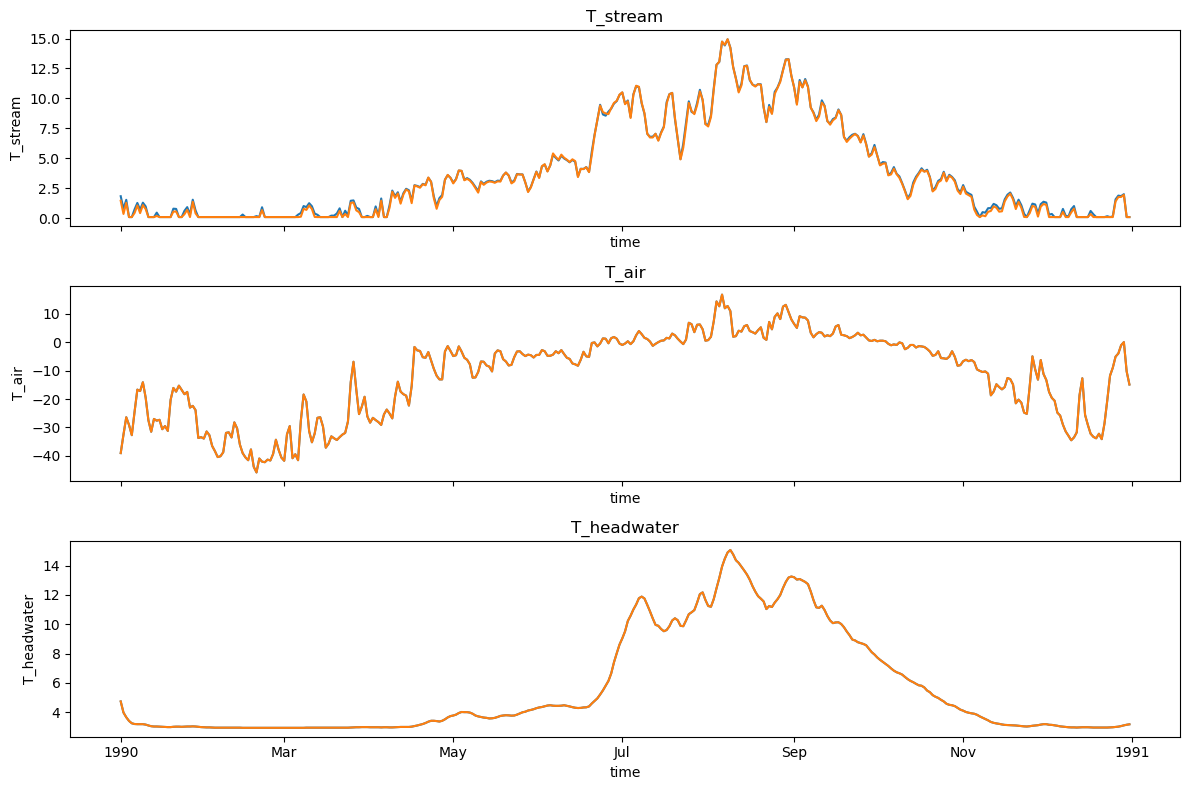

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for ax, var in zip(axes, ["T_stream", "T_air", "T_headwater"]):
    wt_modeled[var].sel(hru=81000076, no_seg=1).plot(ax=ax)
    wt_modeled[var].sel(hru=81000076, no_seg=2).plot(ax=ax)
    ax.set_title(var)

plt.tight_layout()
plt.show()

It looks like the differences between `no_seg` values are pretty small for the `T_stream` variable.

And there are none between them for the other two variables!

In [19]:
assert np.all(
    (wt_modeled["T_air"].sel(no_seg=1).values - wt_modeled["T_air"].sel(no_seg=2).values) == 0
)
assert np.all(
    (
        wt_modeled["T_headwater"].sel(no_seg=1).values
        - wt_modeled["T_headwater"].sel(no_seg=2).values
    )
    == 0
)

##### Streamflow 
`Q` is discharge in m^3/s, here called `IRFroutedRunoff`
For some reason, `seg` refers to the unique ID of the MERIT HYDRO river segment, instead of `hru` used in the water temp file.


In [8]:

q_modeled

<xarray.Dataset> Size: 50MB
Dimensions:          (time: 365, seg: 34346)
Coordinates:
  * time             (time) datetime64[ns] 3kB 1990-01-01T12:00:00 ... 1990-1...
  * seg              (seg) int64 275kB 81003498 81003523 ... 81034852 81034890
Data variables:
    IRFroutedRunoff  (time, seg) float32 50MB ...
Attributes:
    version:  v1.2.1

In [9]:
q_hist

<xarray.Dataset> Size: 53MB
Dimensions:          (time: 365, seg: 35923)
Coordinates:
  * time             (time) datetime64[ns] 3kB 1990-01-01T12:00:00 ... 1990-1...
  * seg              (seg) int64 287kB 81003498 81003523 ... 81034852 81034890
Data variables:
    IRFroutedRunoff  (time, seg) float32 52MB ...
Attributes:
    version:  v1.2.1

Compare modeled vs historical for streamflow from a certain date, segment, and hru.

In [10]:
print(q_modeled['IRFroutedRunoff'].sel(time='1990-01-01', seg=81000076).values)
print(q_hist['IRFroutedRunoff'].sel(time='1990-01-01', seg=81000076).values)

[0.03519676]
[0.02681552]


Let's plot modeled vs historical for all the stream flow values from 1990.

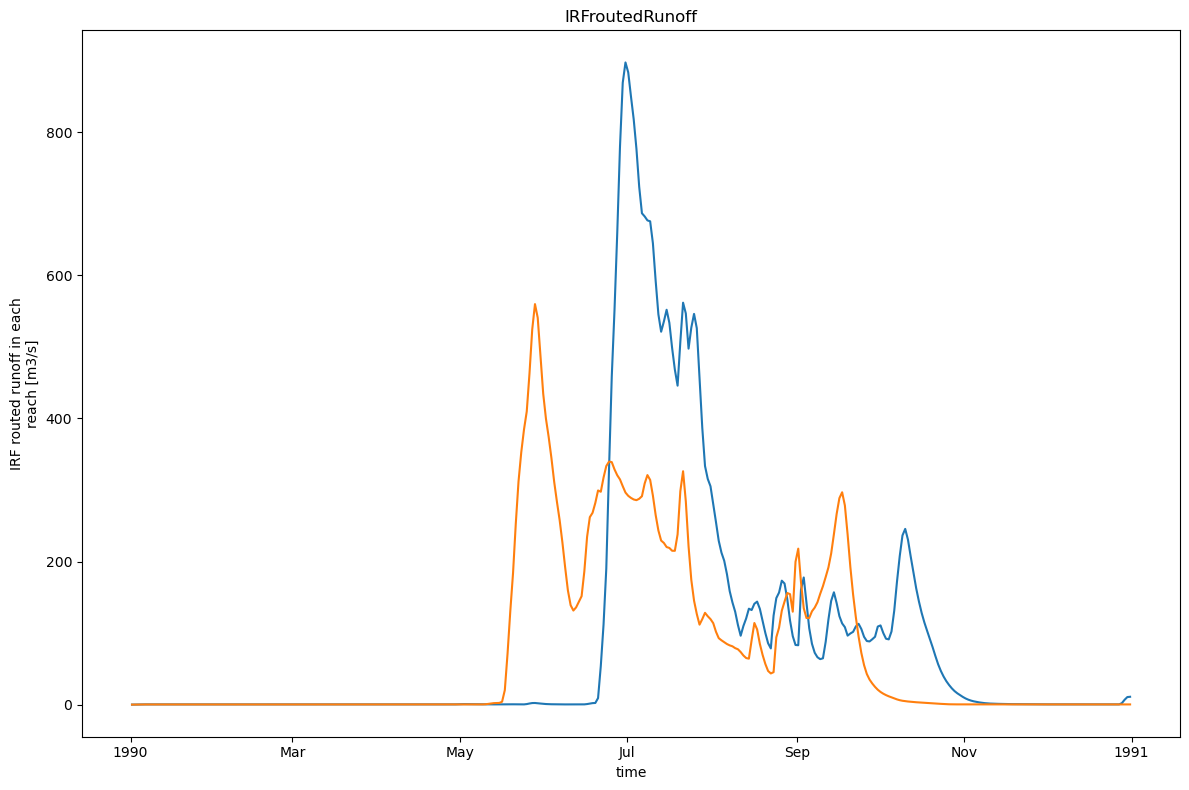

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)

var = 'IRFroutedRunoff'
q_modeled[var].sel(seg=81000076).plot(ax=ax)
q_hist[var].sel(seg=81000076).plot(ax=ax)
ax.set_title(var)

plt.tight_layout()
plt.show()

Interesting... almost seems like the dates may be shifted by a month? Let's investigate this more thoroughly using all the years in the 1990s for that same `hC2LE7` model.

In [23]:
fps_90s = list(data_dir.glob('199*hC2LE7_Q.nc'))
hist_90s = list(data_dir.glob('199*historical_Q.nc'))
fps_90s += hist_90s
fps_90s

[PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1992_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1990_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1996_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1999_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1994_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1998_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1997_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1995_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1993_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1991_hC2LE7_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1992_historical_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/1993_historical_Q.nc'),
 PosixPath('/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Dat

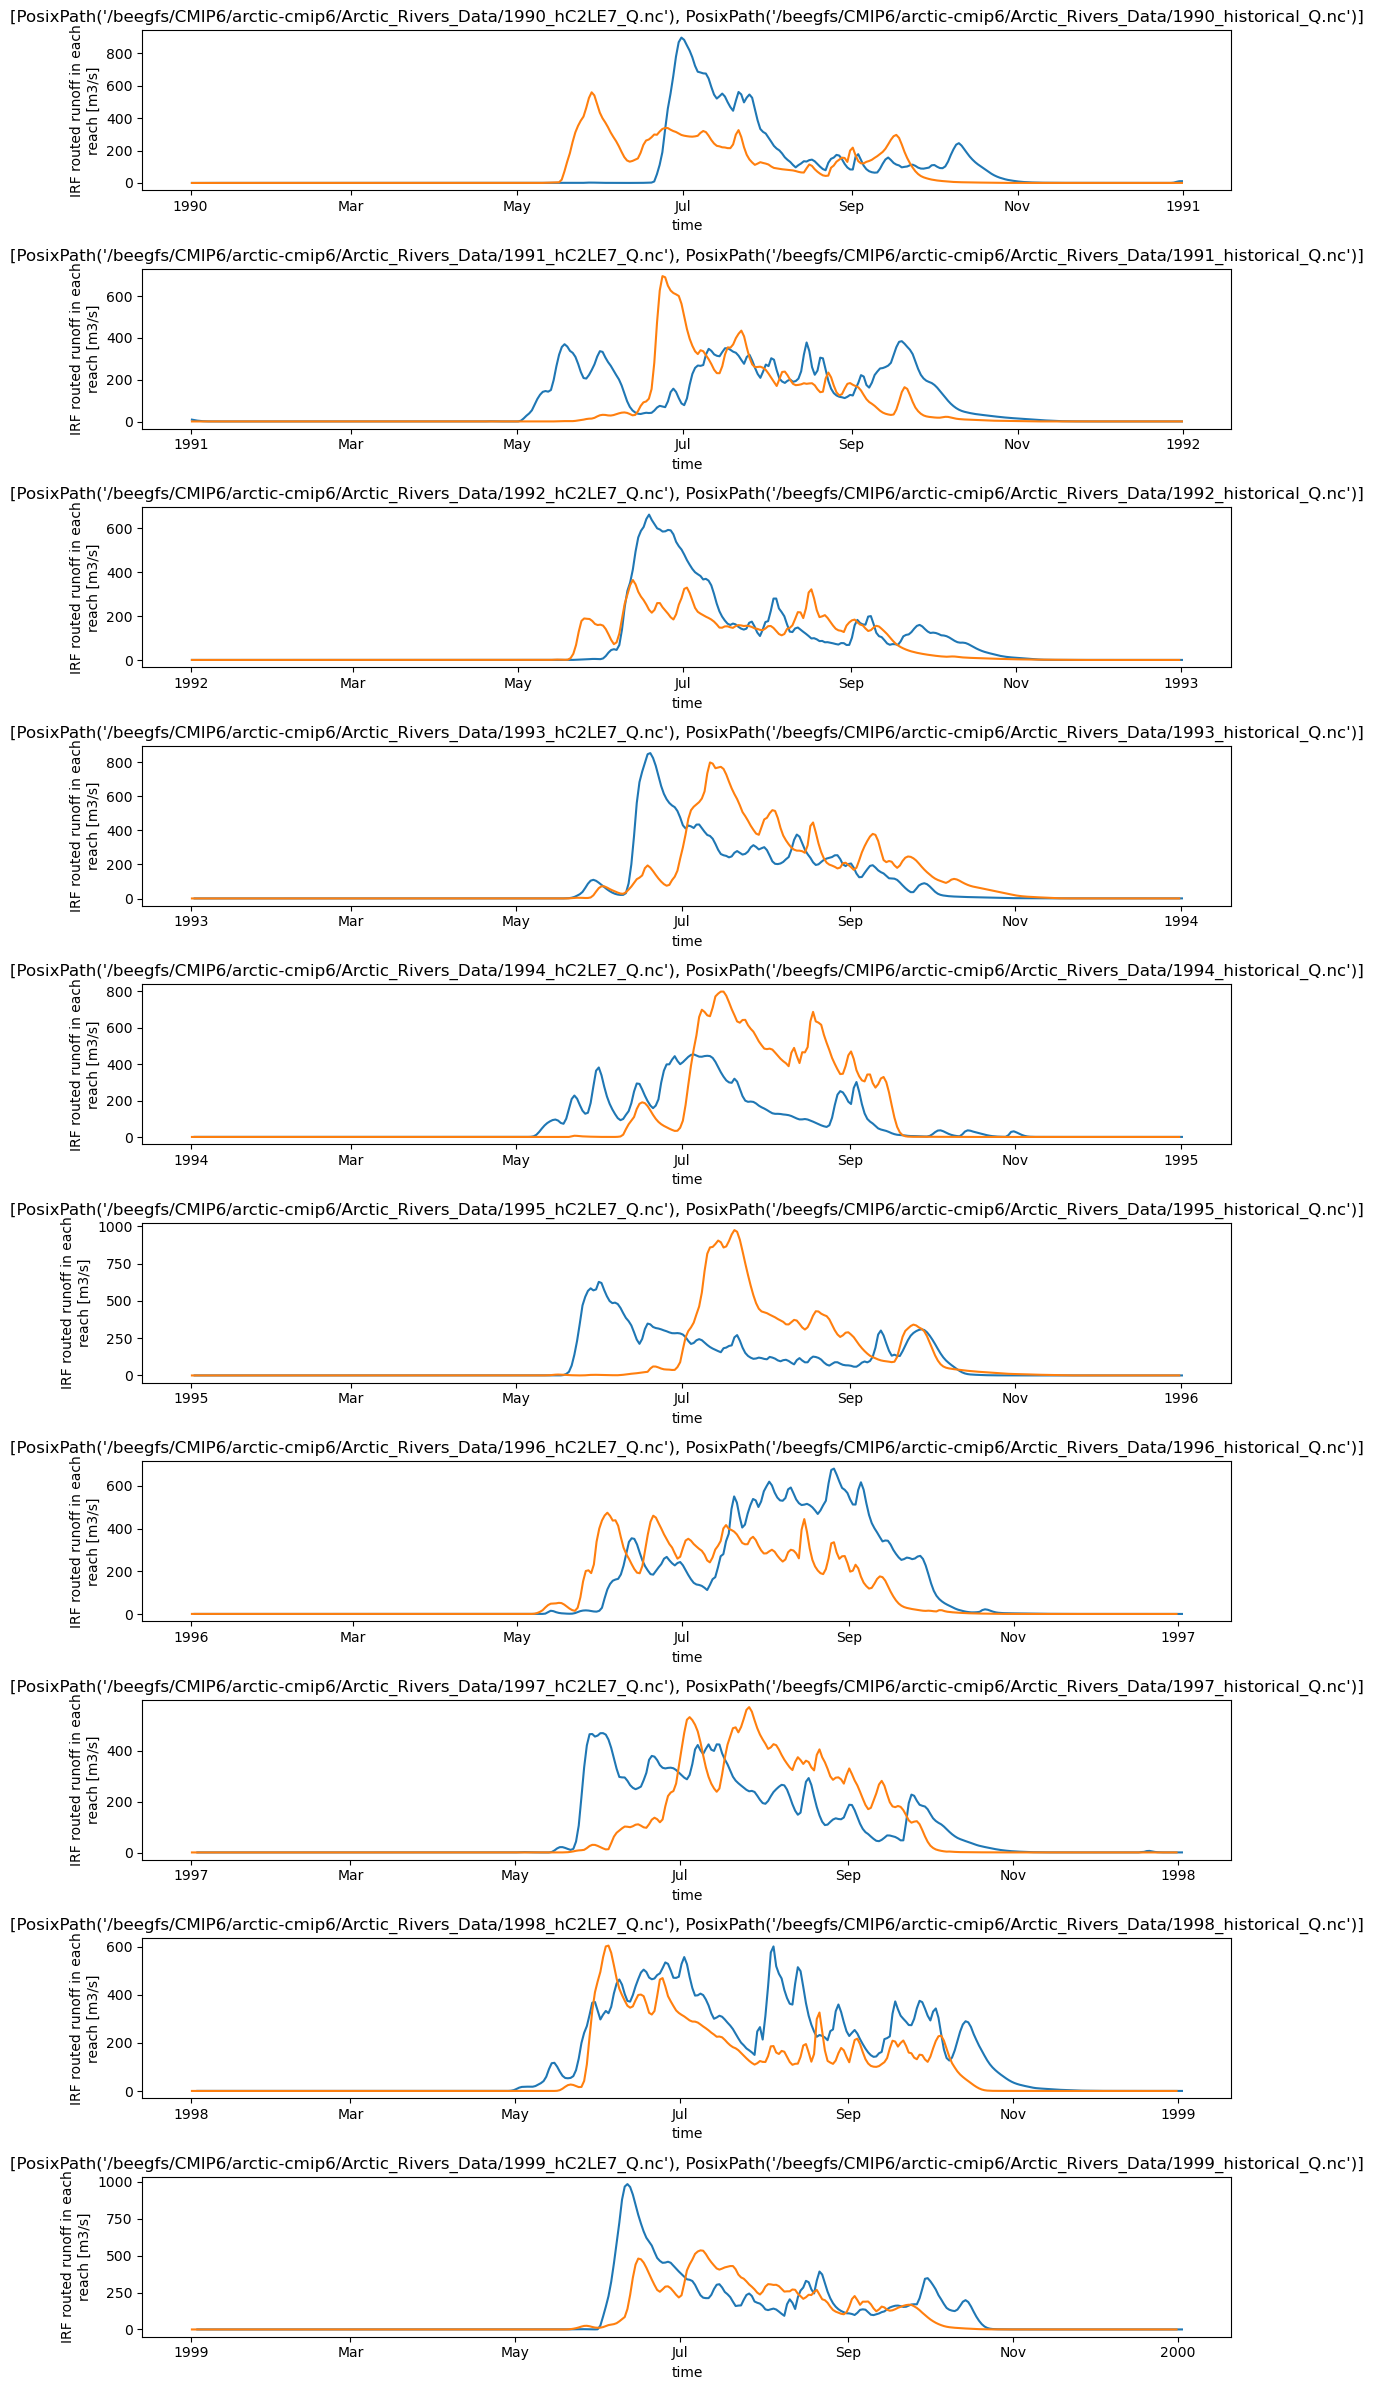

In [27]:
fig, axes = plt.subplots(10, 1, figsize=(12, 24), sharex=False)


for year, ax in zip(range(1990, 2000), range(10)):
    yearly_fps = [fp for fp in fps_90s if str(year) in fp.name]
    for yearly_fp in yearly_fps:
        q_modeled = xr.open_dataset(yearly_fp)
        q_modeled['IRFroutedRunoff'].sel(seg=81000076).plot(ax=axes[ax])
    axes[ax].set_title(yearly_fps)

plt.tight_layout()
plt.show()

OK, it's not a shift in the data timeline, there is just a lot of variation between modeled and historical in start/end of the open water season.

##### Climate
Precipitation, temperature, snow etc. Gridded with XY coords, not river segment IDs.
These are the inputs used to generate the `WT` and `Q` modeled data, maybe not useful in this context?

In [11]:
clim_modeled

<xarray.Dataset> Size: 4GB
Dimensions:        (time: 365, hist_interval: 2, lon: 782, lat: 662)
Coordinates:
  * time           (time) object 3kB 1990-01-02 00:00:00 ... 1991-01-01 00:00:00
  * lon            (lon) float32 3kB 184.2 184.3 184.3 ... 225.7 225.7 225.8
  * lat            (lat) float32 3kB 50.01 50.04 50.07 ... 69.83 69.86 69.89
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds    (time, hist_interval) object 6kB ...
    H2OSNO         (time, lat, lon) float32 756MB ...
    QFLX_EVAP_TOT  (time, lat, lon) float32 756MB ...
    RAIN           (time, lat, lon) float32 756MB ...
    SNOW           (time, lat, lon) float32 756MB ...
    TSA            (time, lat, lon) float32 756MB ...
Attributes: (12/39)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Sat May 18 10:11:35 2024: ncrc...
    source:                                    Community Terrestrial Systems ...
    hostname:                                  derecho
    ...                                        ...
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1
    NCO:                                       netCDF Operators version 5.1.9...

In [12]:
clim_hist

<xarray.Dataset> Size: 4GB
Dimensions:        (time: 365, hist_interval: 2, lon: 782, lat: 662)
Coordinates:
  * time           (time) datetime64[ns] 3kB 1990-01-02 ... 1991-01-01
  * lon            (lon) float32 3kB 184.2 184.3 184.3 ... 225.7 225.7 225.8
  * lat            (lat) float32 3kB 50.01 50.04 50.07 ... 69.83 69.86 69.89
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds    (time, hist_interval) datetime64[ns] 6kB ...
    H2OSNO         (time, lat, lon) float32 756MB ...
    QFLX_EVAP_TOT  (time, lat, lon) float32 756MB ...
    RAIN           (time, lat, lon) float32 756MB ...
    SNOW           (time, lat, lon) float32 756MB ...
    TSA            (time, lat, lon) float32 756MB ...
Attributes: (12/39)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Sat May 18 12:49:37 2024: ncrc...
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1
    NCO:                                       netCDF Operators version 5.1.9...